<a href="https://colab.research.google.com/github/Shahid1993/pytorch-notebooks/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Transfer Learning with PyTorch](https://debuggercafe.com/transfer-learning-with-pytorch/)

## What is Transfer Learning?
Transfer learning is specifically using a neural network that has been pre-trained on a much larger dataset. The main benefit of using transfer learning is that the neural network has already learned many important features from a large dataset. When we use that network on our own dataset, we just need to tweak a few things to achieve good results.

### When to Use Transfer Learning?
In deep learning, transfer learning is most beneficial when we cannot obtain a huge dataset to train our network on. In some cases, we may not be able to get our hands on a big enough dataset. For such situations, using a pre-trained network is the best approach. A pre-trained network has already learned many important intermediate features from a larger dataset. Therefore, we can use that network on our small dataset.

## What Will We Use?
We will use the VGG16 network which uses the weights from the [ImageNet](http://image-net.org/download-imageurls) dataset.

ImageNet contains more than 14 million images covering almost 22000 categories of images. It has held the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) for years so that deep learning researchers and practitioners can use the huge dataset to come up with novel and sophisticated neural network architectures by using the images for training the networks.

## VGG16
The VGG network model was introduced by Karen Simonyan and Andrew Zisserman in the paper named [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf).

The following is the ConvNet Configuration from the original paper.

![](https://debuggercafe.com/wp-content/uploads/2019/12/vgg_convnet_cofig.png)

Specifically, we will be using the 16 layer architecture, which is the VGG16 model. VGG16 has 138 million parameters in total.

### VGG Network Model Results on ImageNet
In 2014, VGG models achieved great results in the ILSVRC challenge. The 16 layer model achieved 92.6% top-5 classification accuracy on the test set. Similarly, the 19 layer model was able to achieve 92.7% top-5 accuracy on the test set.

![](https://debuggercafe.com/wp-content/uploads/2019/12/vgg_imagenet_results-e1576125540844.png)

![](https://debuggercafe.com/wp-content/uploads/2019/12/vgg_voc_cal_results-e1576125629542.png)

# Our Approach
We will use the VGG16 network to classify [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) images.

![](https://debuggercafe.com/wp-content/uploads/2019/12/cifar10_small.jpg)

The CIFAR10 dataset contains images belonging to 10 classes. It has 60000 images in total. There are 50000 images for training and 10000 images for testing. All the images are of size 32×32.

# Importing Required Modules and Libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import models

In [2]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Downloading and Preparing the Dataset

In [3]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Downloading the VGG16 Network

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freezing Convolution Weights
One important thing to notice here is that the classifier model is classifying 1000 classes. You can observe the very last `Linear` block to confirm that. But we need to classify the images into 10 classes only. So, we will change that. Also, we will freeze all the weights of the convolutional blocks. The model as already learned many features from the ImageNet dataset. So, freezing the `Conv2d()` weights will make the model to use all those pre-trained weights. This is the part that really justifies the term transfer learning.

In [0]:
# change the no. of classes
vgg16.classifier[6].out_features = 10

# freeze convolution weights
for param in vgg16.features.parameters():
  param.requires_grad = False

# Optimizer and Loss Function
We will use the `CrossEntropyLoss()` and `SGD()` optimizer which work quite well in most cases. 

In [0]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

# Training and Validation Functions

In [0]:
# validation function
def validate(model, test_dataloader):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0

  for int, data in enumerate(test_dataloader):
    data, target = data[0].to(device), data[1].to(device)
    output = model(data)
    loss = criterion(output, target)

    val_running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    val_running_correct += (preds == target).sum().item()

  val_loss = val_running_loss / len(test_dataloader.dataset)
  val_accuracy = 100 * val_running_correct / len(test_dataloader.dataset)

  print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

  return val_loss, val_accuracy

In [0]:
# training function
def fit(model, train_dataloader):
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0

  for i, data in enumerate(train_dataloader):
    data, target = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    train_running_loss += loss.item()

    _, preds = torch.max(output.data, 1)
    train_running_correct += (preds == target).sum().item()
    loss.backward()
    optimizer.step()
  
  train_loss = train_running_loss / len(train_dataloader.dataset)
  train_accuracy = 100 * train_running_correct / len(train_dataloader.dataset)

  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")

  return train_loss, train_accuracy

# Training the Model

In [9]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

start = time.time()

for epoch in range(20):
  train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
  val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)

  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)

  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

end = time.time()

print((end-start), 'seconds')

Train Loss: 0.0257, Train Acc: 73.43
Validation Loss: 0.0154, Validation Acc: 82.96
Train Loss: 0.0147, Train Acc: 83.62
Validation Loss: 0.0138, Validation Acc: 84.80
Train Loss: 0.0117, Train Acc: 86.89
Validation Loss: 0.0130, Validation Acc: 85.62
Train Loss: 0.0094, Train Acc: 89.49
Validation Loss: 0.0123, Validation Acc: 87.00
Train Loss: 0.0074, Train Acc: 91.72
Validation Loss: 0.0122, Validation Acc: 86.93
Train Loss: 0.0057, Train Acc: 93.62
Validation Loss: 0.0126, Validation Acc: 87.10
Train Loss: 0.0043, Train Acc: 95.34
Validation Loss: 0.0130, Validation Acc: 87.34
Train Loss: 0.0031, Train Acc: 96.70
Validation Loss: 0.0132, Validation Acc: 87.59
Train Loss: 0.0024, Train Acc: 97.54
Validation Loss: 0.0141, Validation Acc: 87.60
Train Loss: 0.0017, Train Acc: 98.27
Validation Loss: 0.0145, Validation Acc: 87.67
Train Loss: 0.0013, Train Acc: 98.70
Validation Loss: 0.0145, Validation Acc: 87.83
Train Loss: 0.0010, Train Acc: 99.08
Validation Loss: 0.0155, Validation Acc

# Visualizing the Plots

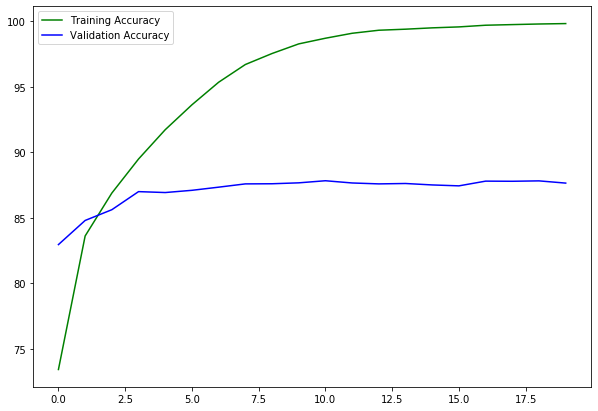

In [10]:
plt.figure(figsize=(10,7))
plt.plot(train_accuracy, color='green', label='Training Accuracy')
plt.plot(val_accuracy, color='blue', label='Validation Accuracy')

plt.legend()
plt.savefig('accuracy.png')
plt.show()

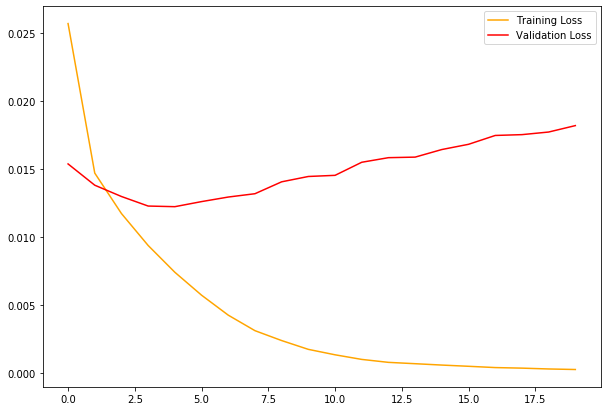

In [11]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='Training Loss')
plt.plot(val_loss, color='red', label='Validation Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()